In [1]:
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import slfmri.lib.io as slio
import matplotlib.lines as mlines
import pickle
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

In [2]:
code = 'E'

iput_pm = slio.PathMan('../Results/UNCCH_CAMRI/130_FeatureDetection')
model_path = iput_pm(f'Filtered_Model_{code}.nii.gz')
model = nib.load(model_path)
mask = nib.load('../Template/Rat_CAMRI_400um_MASK_v2-1.nii.gz')

model_data = np.asarray(model.dataobj)[np.nonzero(mask.dataobj)]
oput_pm = slio.PathMan('../Results/UNCCH_CAMRI/140_Pacellation')

### Kmeans++ initiation

In [3]:
ofname = f'OptParcel_{code}.pkl'
if not os.path.exists(oput_pm(ofname)):
    cluster_range = range(1,200)
    cluster_wss = []
    for num_cluster in tqdm(cluster_range):
        clusters = KMeans(num_cluster, init="k-means++",
                          n_init=100, max_iter=1000, 
                          n_jobs=4)
        clusters.fit(model_data)
        cluster_wss.append(clusters.inertia_)
        
    results = dict(arange = cluster_range,
                   wss = cluster_wss)
    with open(oput_pm(ofname), 'wb') as f:
        pickle.dump(results, f)
else:
    with open(oput_pm(ofname), 'rb') as f:
        results = pickle.load(f)
    cluster_range = results['arange']
    cluster_wss = results['wss']

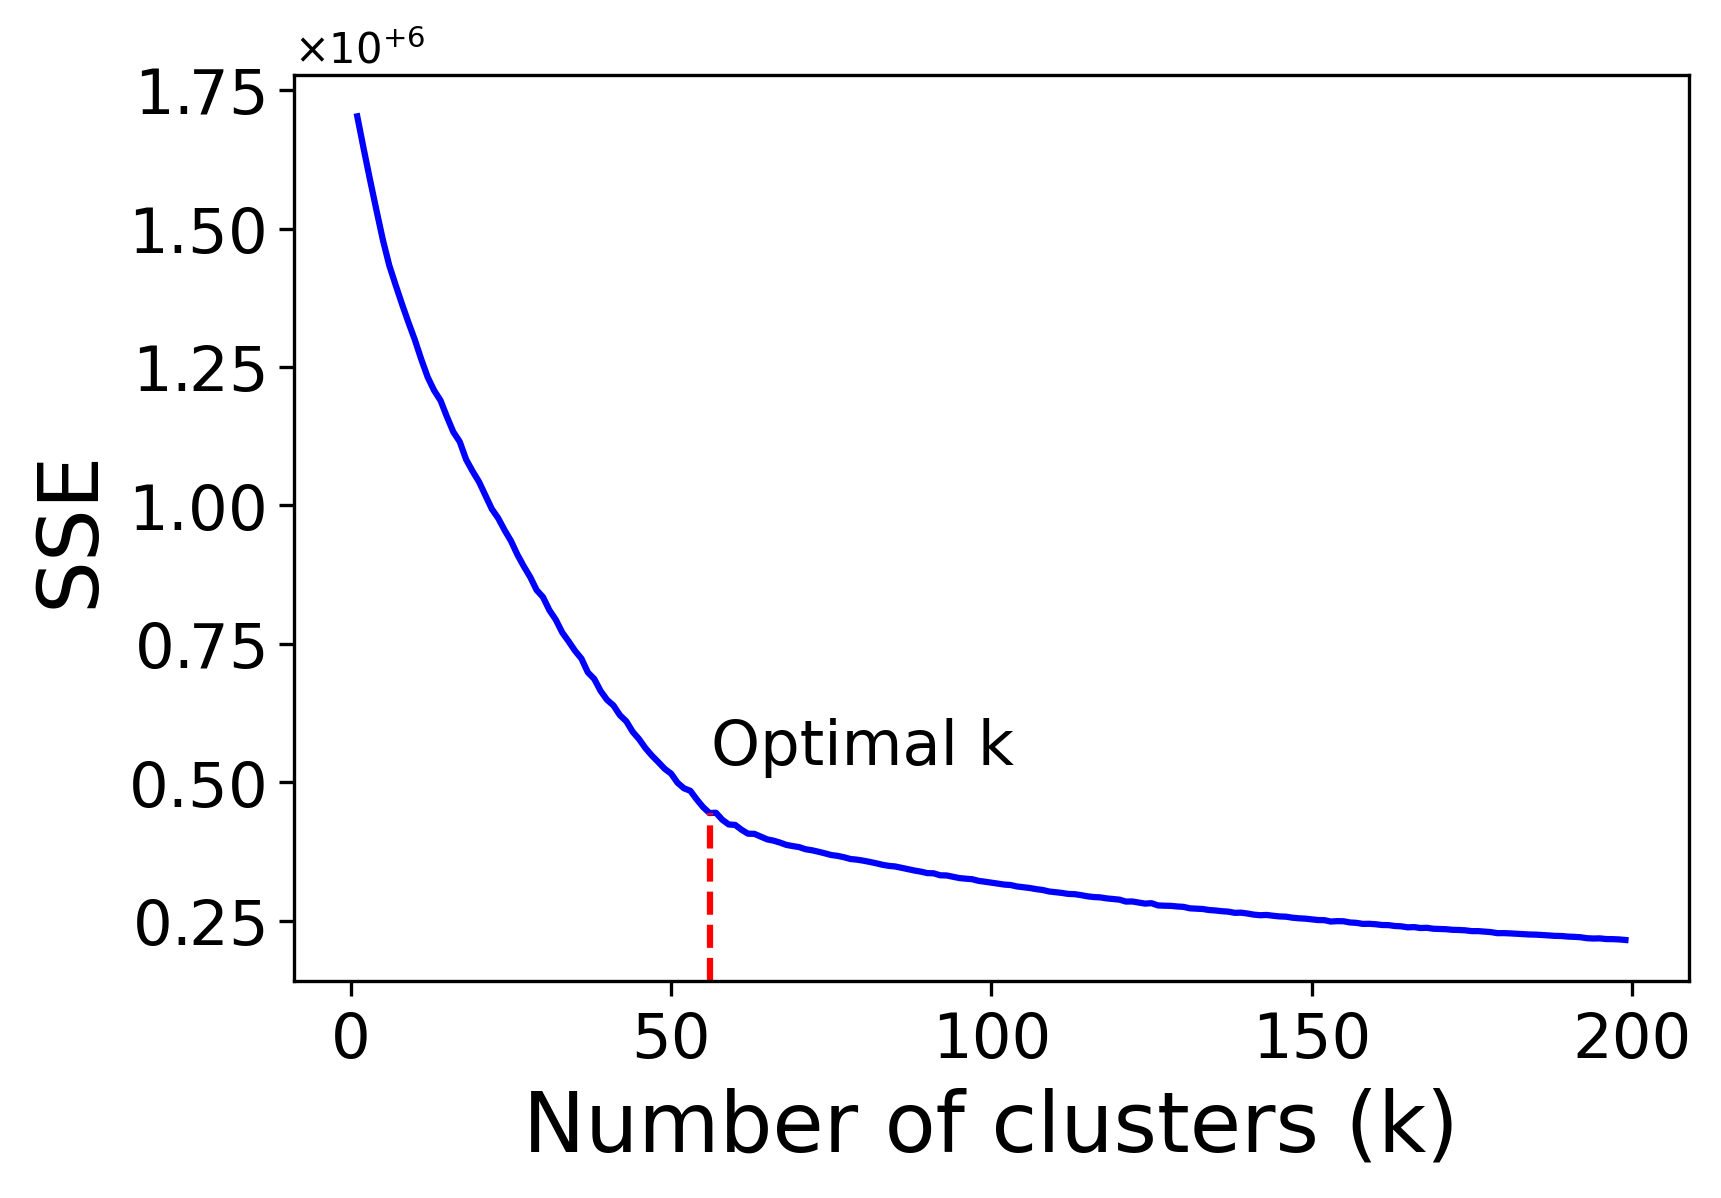

In [4]:
from kneed import KneeLocator
knee = KneeLocator(cluster_range, cluster_wss, curve='convex',
                   direction='decreasing')
fig, ax = plt.subplots(1, 1, dpi=300)

cluster_range = np.array([r for r in cluster_range])
cluster_wss = np.array(cluster_wss)

ax.plot(cluster_range, cluster_wss, 'blue')
y1, y2 = ax.get_ylim()
y2 = cluster_wss[knee.elbow - 1]
l = mlines.Line2D([knee.elbow, knee.elbow], 
                  [y1, y2], color='r', linestyle='--')
ax.add_line(l)
ax.text(knee.elbow + 0.3, cluster_wss[cluster_range == knee.elbow] * 1.2, 'Optimal k', fontsize=15)
ax.set_xlabel('Number of clusters (k)', fontsize=20)
ax.set_ylabel('SSE', fontsize=20)
ax.ticklabel_format(axis='y', style='sci', useMathText=True, useLocale=True,
                           scilimits=[0, 1])
ax.tick_params(axis='both', labelsize=15)

In [ ]:
cluster_wss[cluster_range == knee.elbow]

In [ ]:
cluster_range

## Save to atlas file

In [ ]:
clusters = KMeans(knee.elbow, init="k-means++",
                  n_init=100, max_iter=1000, 
                  n_jobs=4)
clusters.fit(model_data)

print(knee.elbow)
atlas_fname = f'Rat_CAMRI_400um_ATLAS-{knee.elbow}_{code}.nii.gz'
if os.path.exists(oput_pm(atlas_fname)):
    atlas_nii = nib.load(oput_pm(atlas_fname))
else:
    mask_idx = np.nonzero(mask.dataobj)

    atlas = np.zeros(model.shape[:3])
    atlas[mask_idx] = clusters.labels_+1

    atlas_nii = nib.Nifti1Image(atlas, model.affine)
    atlas_nii.header['sform_code'] = 0
    atlas_nii.header['qform_code'] = 1
    atlas_nii.to_filename(oput_pm(atlas_fname))

### Index mapping

Note: the procedure results randomized index so that not matched with previous index of each parcel, so that using below code, re-mapped accordingly to reduce the revision of Figure.

The below code could be deleted, and simplified for publication.

In [32]:
idx_map = {1:51, 2:4, 3:10, 4:29, 5:23,
           6:2, 7:19, 8:33, 9:5, 10:35,
           11:7, 12:18, 13:13, 14:46, 15:28,
           16:22, 17:49, 18:9, 19:37, 20:31,
           21:42, 22:32, 23:6, 24:8, 25:20,
           26:'X', 27:40, 28:21, 29:47, 30:24,
           31:3, 32:11, 33:17, 34:16, 35:38,
           36:1, 37:41, 38:30, 39:36, 40:48,
           41:39, 42:21, 43:53, 44:50, 45:45,
           46:25, 47:52, 48:43, 49:13, 50:12,
           51:26, 52:27, 53:44, 54:33, 55:56,
           56:34,}

In [38]:
parcels = [k for k in idx_map.keys()]
removed = sorted([k for k, v in idx_map.items() if isinstance(v, str)])
reproduced = sorted([v for v in idx_map.values() if isinstance(v, int)])
added = [p for p in parcels if p not in reproduced]

divided = []
for i in set(reproduced):
    num_i = len([r for r in reproduced if r == i])
    if num_i > 1:
        divided.append(i)

In [47]:
divided # 1 of pre divided into 2

[13, 21, 33]

pre(13 + 49) = post(13)  #AUD
pre(28 + 42) = post(21)  #Insula
pre(54 + 8) = post(33)   #Hypo

In [40]:
removed # thalamus

[26]

In [ ]:
[49, 54, 42, 26]

In [39]:
added 

[14, 15, 54, 55]

14 = AUD? (roughly superior part of pre(13), will become pre(49)
15 = posterior part of olfactory, will become pre(54)
54 = secondary sensory? originally excluded areas, will become pre(28)
55 = bilateral cerebellum? originally excluded area - liming think this is part of DMN, will become pre(26)

In [51]:
new_map = {1:51, 2:4, 3:10, 4:29, 5:23,
           6:2, 7:19, 8:33, 9:5, 10:35,
           11:7, 12:18, 13:13, 14:46, 15:28,
           16:22, 17:49, 18:9, 19:37, 20:31,
           21:42, 22:32, 23:6, 24:8, 25:20,
           26:55, 27:40, 28:54, 29:47, 30:24,
           31:3, 32:11, 33:17, 34:16, 35:38,
           36:1, 37:41, 38:30, 39:36, 40:48,
           41:39, 42:21, 43:53, 44:50, 45:45,
           46:25, 47:52, 48:43, 49:14, 50:12,
           51:26, 52:27, 53:44, 54:15, 55:56,
           56:34,}

In [56]:
new_path = '../Results/UNCCH_CAMRI/140_Pacellation/Rat_CAMRI_400um_ATLAS-56_E.nii.gz'

new_nii = nib.load(new_path)
new_data = np.asarray(new_nii.dataobj)

reorg_data = np.zeros(new_nii.shape)

for old_i, new_i in new_map.items():
    roi_mask = np.nonzero((new_data == new_i).astype(int))
    reorg_data[roi_mask] = old_i

In [60]:
reorg_nii = nib.Nifti1Image(reorg_data, affine=new_nii.affine)
reorg_nii._header = new_nii._header
reorg_path = '../Results/UNCCH_CAMRI/140_Pacellation/Rat_CAMRI_400um_ATLAS-56_E_reorg.nii.gz'

reorg_nii.to_filename(reorg_path)

## Remove regions out of interest.

In [64]:
flt_fname = f'Rat_CAMRI_400um_ATLAS-filtered_{code}.nii.gz'
flt_path = oput_pm(flt_fname)

if os.path.exists(flt_path):
    parcels_nii = nib.load(flt_path)
else:    
    # Add here the indexes of ROI to be excluded
    vas = [5, 
           6, 
           12, # transverse sinus
           21, 
           23, # transverse sinus
           33
          ]
    niiobj = nib.load(reorg_path)
    dataobj = np.asarray(niiobj.dataobj)
    for i, v in enumerate(vas):
        v_mask = np.nonzero(dataobj == (v - i))
        dataobj[v_mask] = 0
        dataobj[dataobj > (v - i)] -= 1

    parcels_nii = nib.Nifti1Image(dataobj, niiobj.affine)
    parcels_nii._header = parcels_nii._header
    parcels_nii.to_filename(flt_path)

In [16]:
num_parcels = int(dataobj.max())
print(f'num_parcels: {num_parcels}')

num_parcels: 50


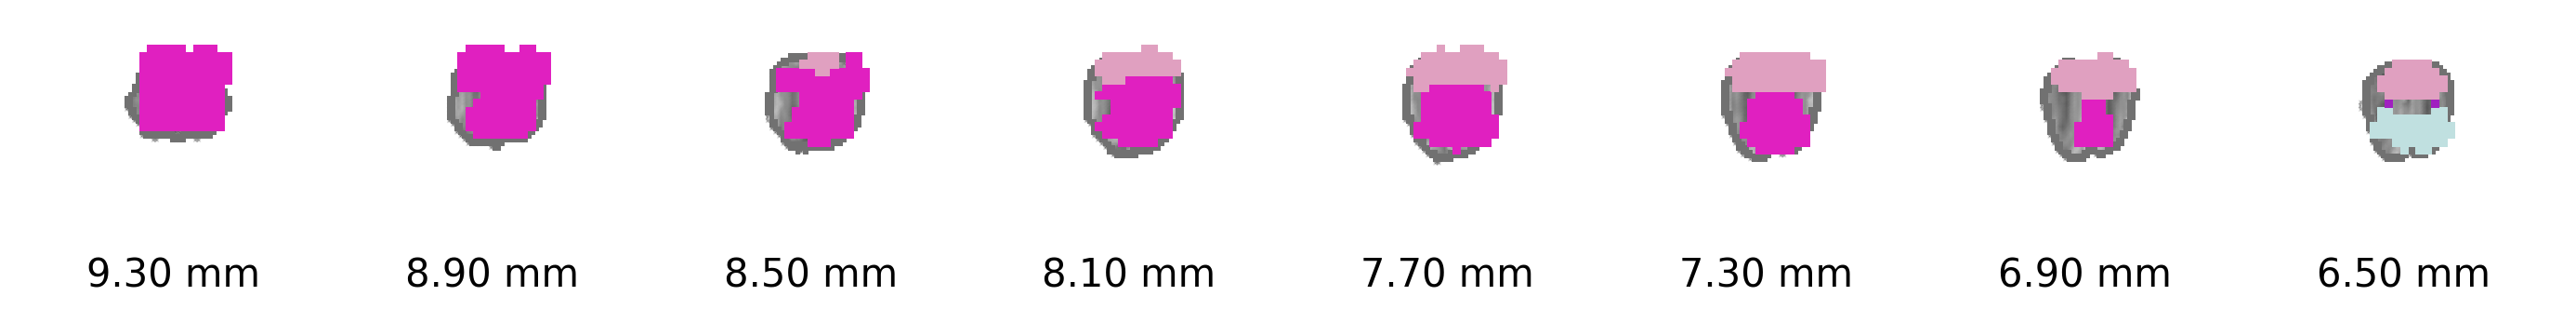

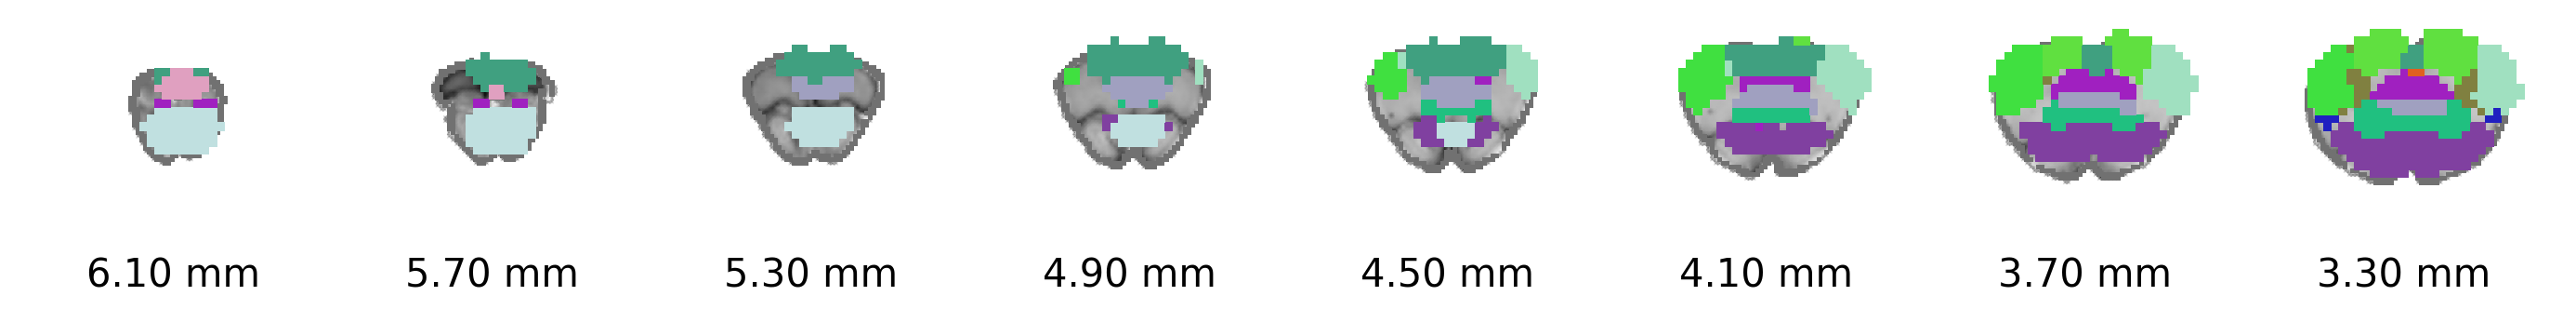

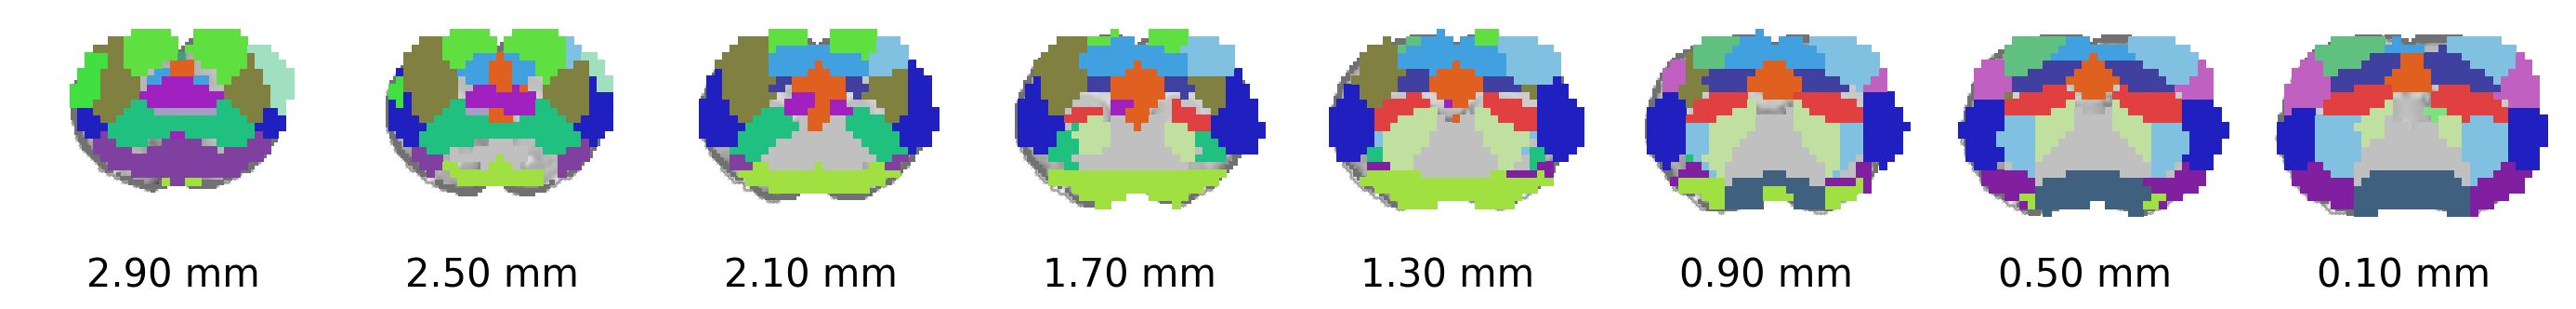

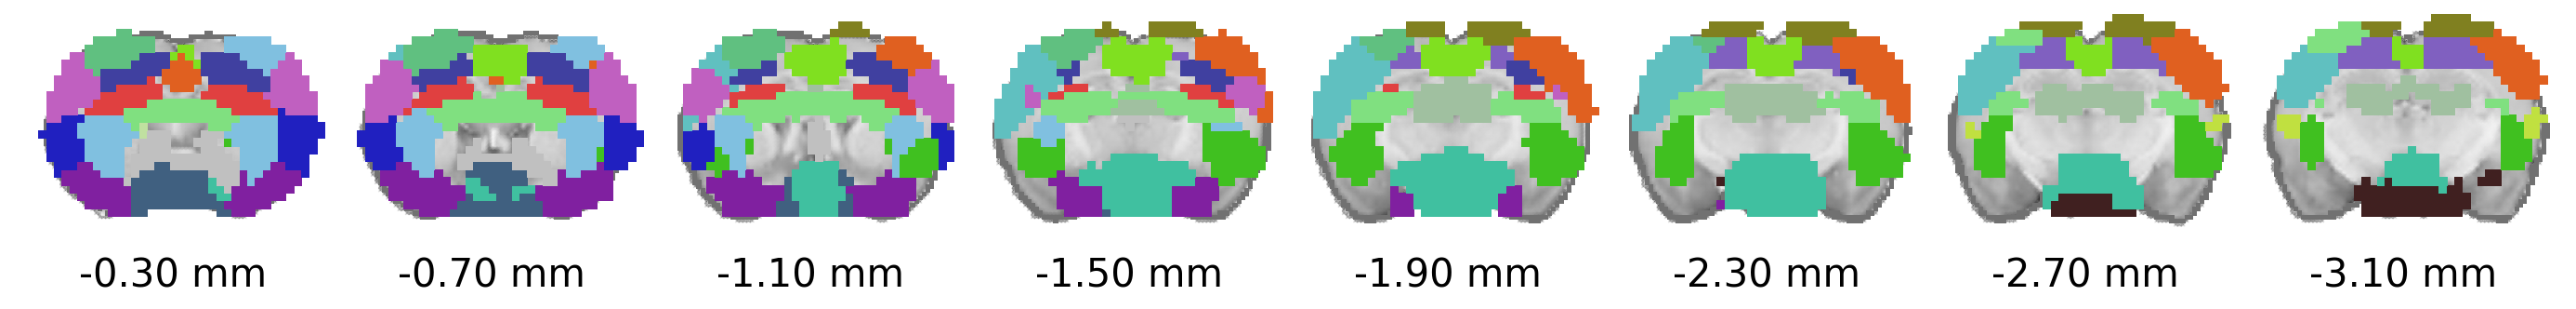

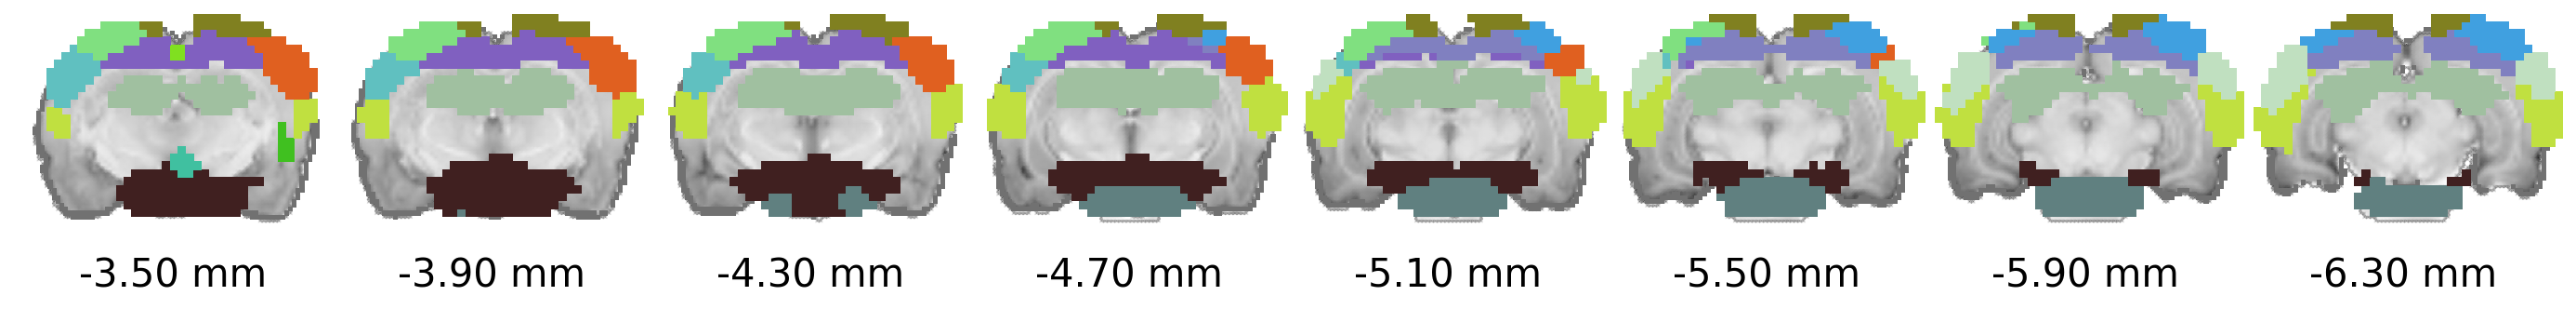

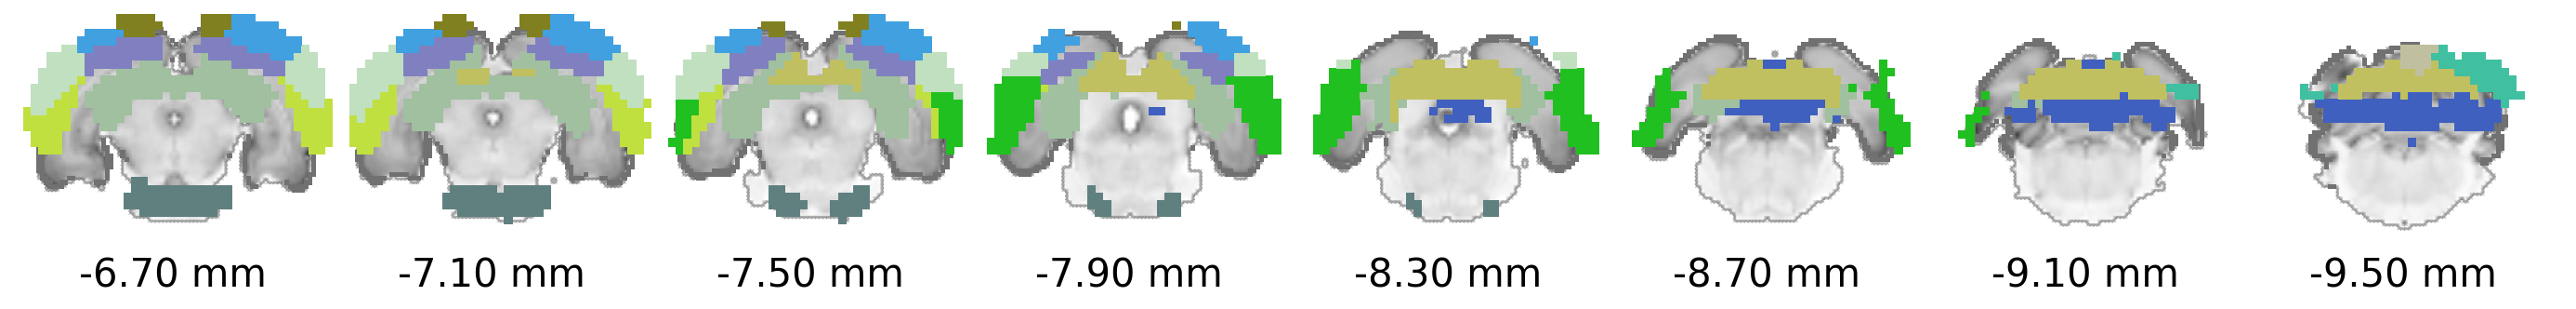

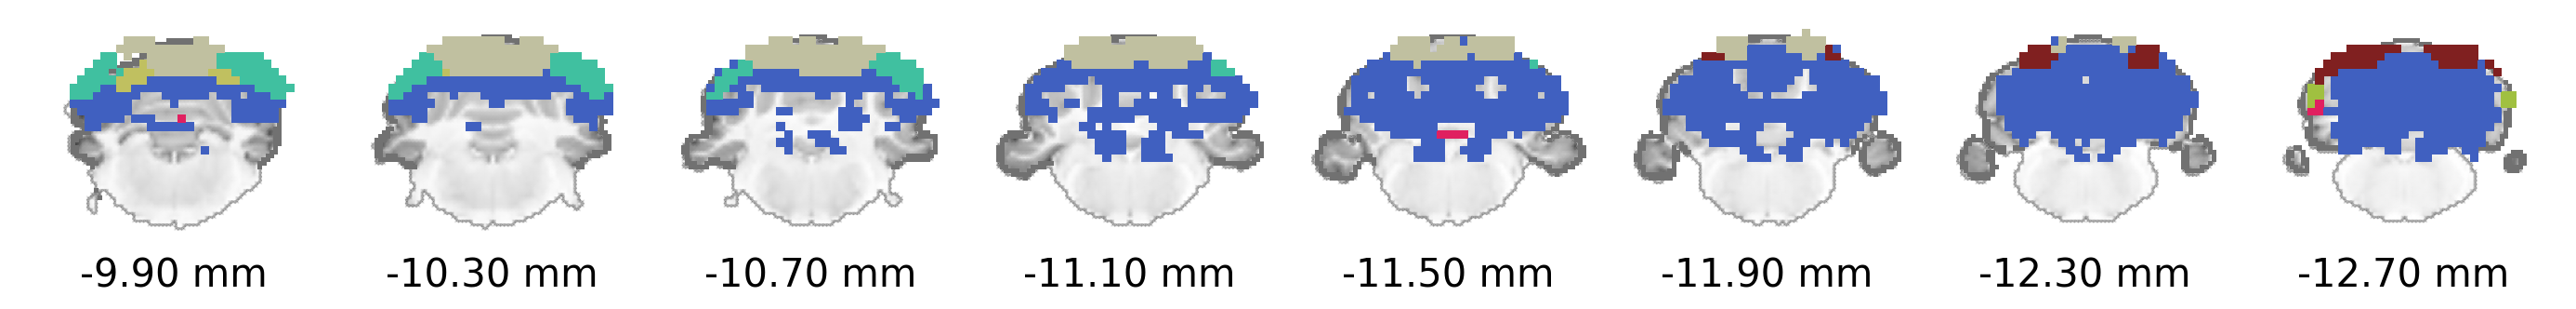

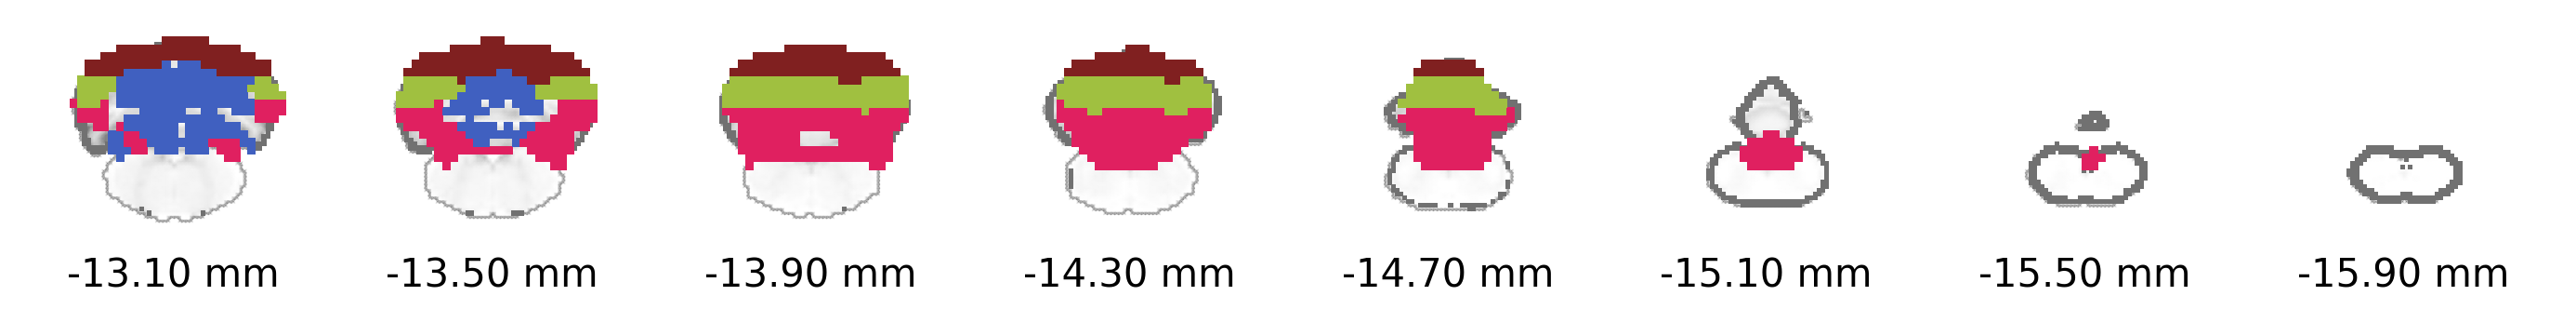

In [2]:
from custom_module import mosaicview_paxinos, crop_by_voxel, pad_by_voxel, norm_orient, correct_affine, thr_by_z, thr_by_voxelsize
from slfmri import io as slio

from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

anat_path = '../Template/Rat_Paxinos_200um_Template.nii.gz'
anat_obj = nib.load(anat_path)
anat_obj = crop_by_voxel(pad_by_voxel(norm_orient(anat_obj), a=2), l=30, r=30)
anat_obj = correct_affine(anat_obj)

func_obj = nib.load(flt_path)
func_obj = crop_by_voxel(pad_by_voxel(norm_orient(func_obj), a=1), l=15, r=15)
func_obj = correct_affine(func_obj)
alpha = 1

n_bin = np.asarray(func_obj.dataobj).max()
atlas = slio.Atlas(flt_path)
cmap = LinearSegmentedColormap.from_list('test', list(atlas.cmap.values()), N=n_bin+1)

affine = func_obj.affine.copy()
slice_coords = np.linspace(10.9, -17.5, 72)[4:-4] # All slices coordinates

for init in range(0, len(slice_coords), 8):
    selected_slices = slice_coords[np.arange(0, len(slice_coords), 1)][init:init+8]
    fig = mosaicview_paxinos(anat_obj, func_obj, selected_slices, dpi=300,
                             navi=False, annotate=True, vmin=0, vmax=n_bin, cmap=cmap, alpha=alpha, fontsize=20)